In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import cv2
import os

In [3]:
print(os.listdir("/gdrive/My Drive/Retinal Imaging/Eyes"))

['Normal', 'Diabetic Retinopathy', 'Glaucoma', 'Cataract']


In [4]:
DATADIR = "/gdrive/My Drive/Retinal Imaging/Eyes"

CATEGORIES = ["Cataract","Diabetic Retinopathy","Glaucoma","Normal"]

In [5]:
IMG_SIZE = 50

In [6]:
all_data = []

def create_all_data():
    for category in CATEGORIES:
        path = os.path.join(DATADIR, category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img))
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                all_data.append([new_array, class_num])
            except Exception as e:
                pass

create_all_data()

In [8]:
print("Toplam Görüntü Sayısı: ", len(all_data))

Toplam Görüntü Sayısı:  4217


In [7]:
X = []
y = []

for categories, label in all_data:
  X.append(categories)
  y.append(label)

In [9]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state =42)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.10, random_state=42)

In [10]:
x_train = np.array(x_train)
x_test = np.array(x_test)

y_train = np.array(y_train)
y_test = np.array(y_test)

x_val = np.array(x_val)
y_val = np.array(y_val)

In [11]:
print(x_train.shape)
print(x_test.shape)
print(x_val.shape)

print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(3035, 50, 50, 3)
(844, 50, 50, 3)
(338, 50, 50, 3)
(3035,)
(844,)
(338,)


In [12]:
x_train = x_train.astype('float32')
x_val = x_val.astype('float32')
x_test = x_test.astype('float32')

In [13]:
import tensorflow as tf

train_yCl = tf.keras.utils.to_categorical(y_train, num_classes=4)
test_yCl = tf.keras.utils.to_categorical(y_test, num_classes=4)
valid_yCl = tf.keras.utils.to_categorical(y_val, num_classes=4)

In [14]:
from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.models import Sequential

In [15]:
res = tf.keras.applications.ResNet50V2(
    input_shape=(50, 50, 3),
    include_top = False
)

94668760/94668760 [==============================] - 4s 0us/step


In [16]:
res_model = Sequential()
res_model.add(res)
res_model.add(Dropout(0.25))
res_model.add(MaxPooling2D())
res_model.add(Flatten())
res_model.add(Dense(256, activation='relu'))
res_model.add(BatchNormalization())
res_model.add(Dropout(0.5))
res_model.add(Dense(4, activation='softmax'))

In [17]:
res_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [18]:
history = res_model.fit(x_train, train_yCl,
                        batch_size=120,
                        epochs=10,
                        validation_data=(x_val, valid_yCl))

Epoch 1/10
26/26 [==============================] - 418s 15s/step - loss: 1.1820 - accuracy: 0.5885 - val_loss: 169.5184 - val_accuracy: 0.2278
Epoch 2/10
26/26 [==============================] - 406s 16s/step - loss: 0.6043 - accuracy: 0.7565 - val_loss: 107.4766 - val_accuracy: 0.3254
Epoch 3/10
26/26 [==============================] - 412s 16s/step - loss: 0.4389 - accuracy: 0.8283 - val_loss: 17.3807 - val_accuracy: 0.3905
Epoch 4/10
26/26 [==============================] - 422s 16s/step - loss: 0.3497 - accuracy: 0.8675 - val_loss: 5.7834 - val_accuracy: 0.6391
Epoch 5/10
26/26 [==============================] - 409s 16s/step - loss: 0.2583 - accuracy: 0.9074 - val_loss: 3.2506 - val_accuracy: 0.5740
Epoch 6/10
26/26 [==============================] - 407s 16s/step - loss: 0.2354 - accuracy: 0.9124 - val_loss: 1.7715 - val_accuracy: 0.7308
Epoch 7/10
26/26 [==============================] - 428s 16s/step - loss: 0.2328 - accuracy: 0.9163 - val_loss: 1.0727 - val_accuracy: 0.7988
E

In [19]:
score_valid = res_model.evaluate(x_val, valid_yCl)
print("Validation Accuracy: ", score_valid[1])

score_test = res_model.evaluate(x_test, test_yCl)
print("Test Accuracy: ", score_test[1])

score_train = res_model.evaluate(x_train, train_yCl)
print("Train Accuracy: ", score_train[1])

11/11 [==============================] - 5s 430ms/step - loss: 0.7486 - accuracy: 0.8047
Validation Accuracy:  0.8047337532043457
27/27 [==============================] - 10s 354ms/step - loss: 0.6531 - accuracy: 0.8258
Test Accuracy:  0.8258293867111206
95/95 [==============================] - 35s 373ms/step - loss: 0.2782 - accuracy: 0.9120
Train Accuracy:  0.9120263457298279


In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Test verisi üzerinde tahminlerde bulunun
y_pred_probs = res_model.predict(x_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Gerçek sınıfları alın
y_true_classes = np.argmax(test_yCl, axis=1)

# Accuracy
accuracy = accuracy_score(y_true_classes, y_pred_classes)
print(f"Accuracy: {accuracy}")

# Precision
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
print(f"Precision: {precision}")

# Recall
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
print(f"Recall: {recall}")

# F1 Score
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')
print(f"F1-Score: {f1}")

# Classification Report
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes))

# Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
print("Confusion Matrix:")
print(cm)

27/27 [==============================] - 10s 342ms/step
Accuracy: 0.8258293838862559
Precision: 0.8481651794550216
Recall: 0.8258293838862559
F1-Score: 0.8269089357650466
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.66      0.78       233
           1       0.98      1.00      0.99       224
           2       0.65      0.84      0.73       188
           3       0.76      0.81      0.79       199

    accuracy                           0.83       844
   macro avg       0.84      0.83      0.82       844
weighted avg       0.85      0.83      0.83       844

Confusion Matrix:
[[154   0  53  26]
 [  0 223   1   0]
 [  5   1 158  24]
 [  3   3  31 162]]


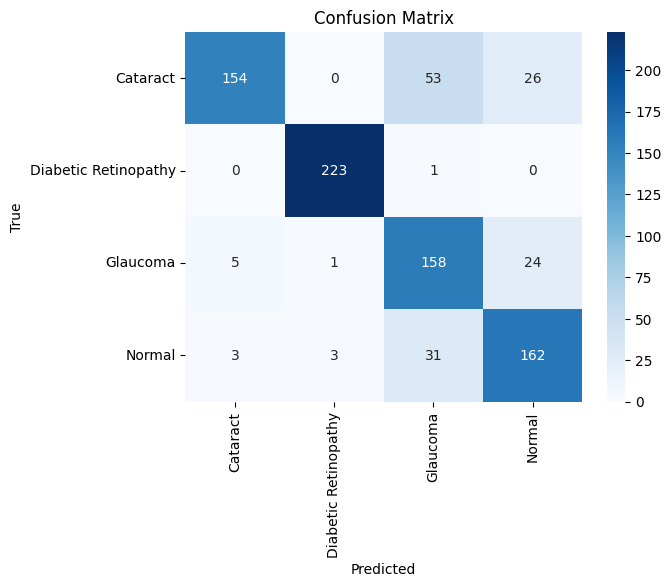

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true_classes, y_pred_classes)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=CATEGORIES, yticklabels=CATEGORIES)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
